In [3]:
#Let's begin with importing the MNIST Dataset
# As by default Scikit-Learn already have Dataset

In [4]:
#Firstly update the Python, Scikit and import few Libraries we know we will be needing in the project

import sklearn
assert sklearn.__version__ >= "0.20"
import sys
assert sys.version_info >= (3, 5)
import numpy as np
import os


In [5]:
from sklearn.datasets import fetch_openml as fetopml

mnist=fetopml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [6]:
#Let's quick peak 
X,y=mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [7]:
#70,000 dataset with 784 features 
#we can take 60,000 as training Dataset


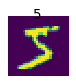

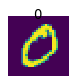

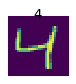

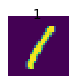

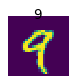

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

for x in range(5):
    digits=X[x]
    digits_img=digits.reshape(28,28)
    plt.figure(num=y[x], figsize=(1,1), dpi=80)
    plt.suptitle(y[x])
    plt.imshow(digits_img)
    plt.axis("off")
    plt.show()



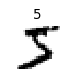

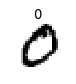

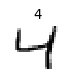

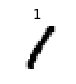

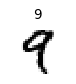

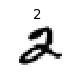

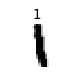

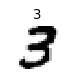

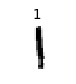

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

for x in range(9):
    digits=X[x]
    digits_img=digits.reshape(28,28)
    plt.figure(num=y[x], figsize=(1,1), dpi=80)
    plt.suptitle(y[x])
    plt.imshow(digits_img,cmap='binary')
    plt.axis("off")
    plt.show()


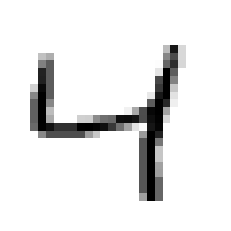

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt


some_digits=X[2]
some_digits_img=some_digits.reshape(28,28)
plt.imshow(some_digits_img,cmap='binary')
plt.axis("off")
plt.show()

In [11]:
#Since the dataset is already shuffled and independent of biasing so we will simply slice the array in Training and Test set
x_train,x_test=X[:60000], X[60000:]
y_train,y_test=y[:60000], y[60000:]

In [12]:
#Lets try to make a Binary Classifier to check the Digit 4
y_train = y_train.astype(np.int8)
y_train_4=(y_train==4)
y_test_4=(y_test==4)



In [13]:
#let try to work out with the Stochastic Gradient Descent classier
#We will be using it as Binary Classifier i.e. we will check whether the figure is 7 or not 7
from sklearn.linear_model import SGDClassifier 

sgd=SGDClassifier(max_iter=1000, tol=1e-3,random_state=42)
sgd.fit(x_train, y_train_4)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd.predict([some_digits])

array([ True])

In [15]:
#Check the accuracy by cross validation the Binary SGD Classifier

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds=StratifiedKFold(n_splits=3)

for train_index,test_index in skfolds.split(x_train,y_train_4):
    clone_clf=clone(sgd)
    x_train_folds=x_train[train_index]
    y_train_folds=y_train_4[train_index]
    
    x_test_folds=x_train[test_index]
    y_test_folds=y_train_4[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred=clone_clf.predict(x_test_folds)
    n_correct=sum(y_pred==y_test_folds)
    print("Accuracy::",n_correct/len(y_pred))

Accuracy:: 0.9671
Accuracy:: 0.97645
Accuracy:: 0.9687


In [16]:
from sklearn.model_selection import cross_val_score as cvs

cvs(sgd,x_train,y_train_4,cv=3,scoring="accuracy")


array([0.9671 , 0.97645, 0.9687 ])

In [17]:
#lets Check the NOT-4 prediction accuracy of the model
from sklearn.base import BaseEstimator 

class Not4clf(BaseEstimator):
    def fit(self,x,y=None):
        return self;
    
    def predict(self,x):
        return np.zeros((len(x),1),dtype=bool)



In [18]:
#Let's test the accuracy of how well we can predict that the value isn't " 4 "
from sklearn.model_selection import cross_val_score as cvs

never_4=Not4clf()
cvs(never_4,x_train,y_train_4,cv=3,scoring="accuracy")

array([0.90275, 0.9018 , 0.90335])

In [19]:
#Let's create the CONFUSION MATRIX 
from sklearn.model_selection import cross_val_predict as cvpred

y_train_pred=cvpred(sgd,x_train,y_train_4,cv=3)
y_train_pred

array([False, False,  True, ..., False, False, False])

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_4,y_train_pred)

array([[52957,  1201],
       [  554,  5288]], dtype=int64)

In [21]:
from sklearn.metrics import confusion_matrix

y_train_perfect_predictions=y_train_4

confusion_matrix(y_train_4,y_train_perfect_predictions)

array([[54158,     0],
       [    0,  5842]], dtype=int64)

In [22]:
# Checking up the binary classifer on Precision and Recall
from sklearn.metrics import precision_score as prsc , recall_score as resc

print("Precision Score::",prsc(y_train_4,y_train_pred))

print("Recall Score::",resc(y_train_4,y_train_pred))

Precision Score:: 0.8149175527816305
Recall Score:: 0.905169462512838


In [23]:
from sklearn.metrics import f1_score 

f1_score(y_train_4,y_train_pred)

0.8576757764982564

In [24]:
y_scores=sgd.decision_function([some_digits])
y_scores

array([3214.66574913])

In [25]:
# Changing the Threshold value for the Precision/Recall Trade off and calibrate it to the best possible combination of P/R 
threshold=0
y_some_digits_pred=(y_scores>threshold)
y_some_digits_pred


array([ True])

In [26]:
threshold=5000
y_some_digits_pred=(y_scores>threshold)
y_some_digits_pred


array([False])

In [27]:
# HIT & TRIAL can take very long time to find the accurate P/R Trade off
y_scores=cvpred(sgd,x_train,y_train_4,cv=3,method="decision_function")
y_scores

array([-31754.76525516, -26393.82888302,   2160.11030898, ...,
       -19439.69962707, -10979.35873154, -22487.33775957])

In [28]:
# Simply we can go for P/R Curve and use our Graphical tool kit to find the optimals values
from sklearn.metrics import precision_recall_curve as prcurve

precisions,recalls,thresholds=prcurve(y_train_4,y_scores)
print("Precision::",precisions)
print("Recalls::",recalls)
print("Threshold::",thresholds)

Precision:: [0.10262626 0.1026105  0.1026123  ... 1.         1.         1.        ]
Recalls:: [1.00000000e+00 9.99828826e-01 9.99828826e-01 ... 3.42348511e-04
 1.71174255e-04 0.00000000e+00]
Threshold:: [-61778.26334052 -61768.78294136 -61764.89465536 ...  42016.20158046
  42674.90852649  44388.35162874]


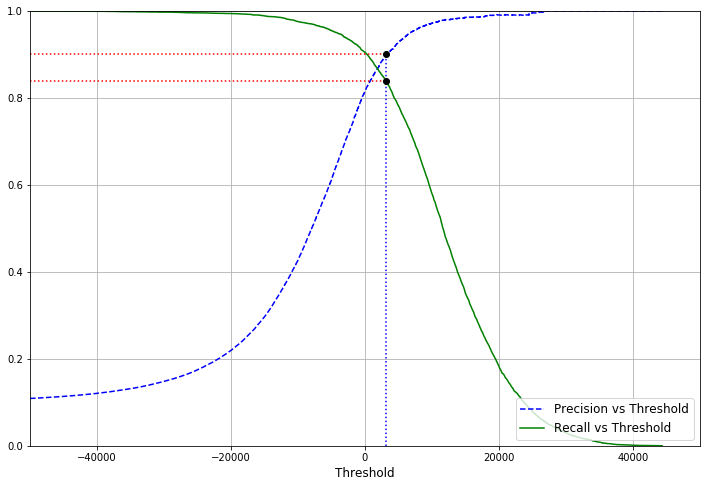

In [29]:
# Plotting the P/R Curve against Thresholds
def plot_prcurve(precisions,recalls,thresholds=0):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision vs Threshold")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall vs Threshold")
      
    plt.grid()
    plt.legend(loc="lower right", fontsize=12) 
    plt.xlabel("Threshold", fontsize=12)        
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(12, 8)) 
plot_prcurve(precisions,recalls,thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "b:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ko")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ko")


plt.savefig('.\\ImageDataset\\PRVSThresholdCurve.jpeg')
plt.show() 

In [30]:
thresholds_90_precision=thresholds[np.argmax(precisions>=0.90)]
y_train_pred_90=(y_scores >=thresholds_90_precision)

print("Precision Score ::",prsc(y_train_4,y_train_pred_90))
print("Recall Score at 90% Precision::",resc(y_train_4,y_train_pred_90))


Precision Score :: 0.9001287474710318
Recall Score at 90% Precision:: 0.8377268058883944


No handles with labels found to put in legend.


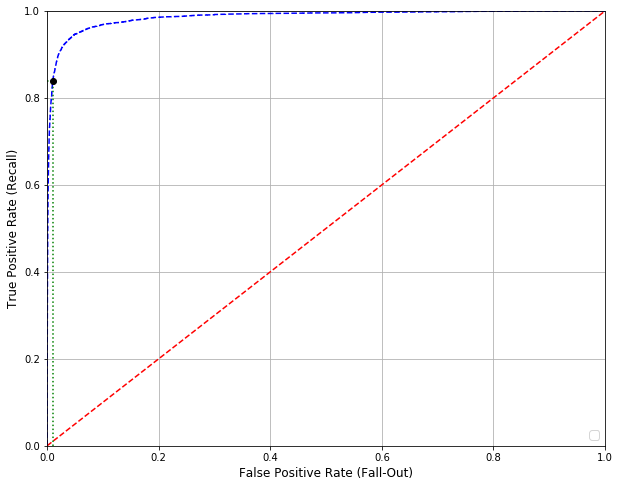

In [31]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds=roc_curve(y_train_4,y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,"b--",label=label)
    plt.plot([0,1],[0,1],'r--')
    plt.axis([0, 1, 0, 1])  
    plt.grid()
    plt.legend(loc="lower right", fontsize=12) 
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)    
    
    fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
    
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "g:")
    plt.plot([0.0,fpr_90],[recall_90_precision,recall_90_precision],"g:")
    plt.plot([fpr_90], [recall_90_precision], "ko") 
   
    
plt.figure(figsize=(10, 8))
plot_roc_curve(fpr,tpr)
plt.savefig('.\\ImageDataset\\ROCCurve.jpeg')
plt.show() 

In [32]:

from sklearn.metrics import roc_auc_score as rocscr #AUC == Area Under Curve

rocscr(y_train_4,y_scores)

0.9859276923382874

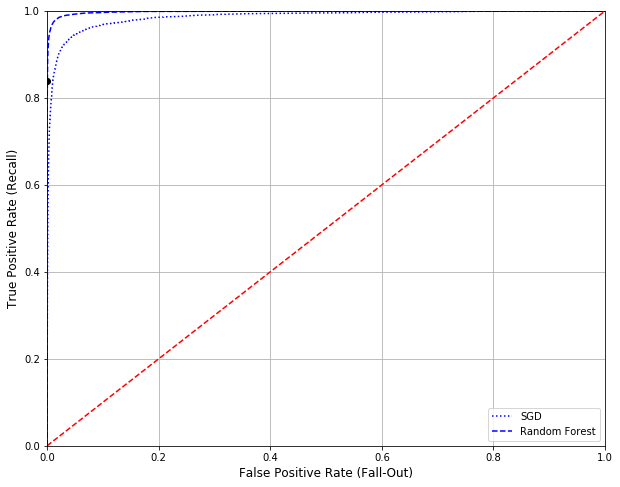

In [33]:
#Lets Train the Random Forest Classifier  

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict as cvpred

forest=RandomForestClassifier(random_state=42,n_estimators=100)
y_probas_forest=cvpred(forest,x_train,y_train_4,cv=2,method="predict_proba")

y_scores_forest=y_probas_forest[:,1]
fpr_forest,tpr_forest,threshold_forest=roc_curve(y_train_4,y_scores_forest)

#We set the parameters....
#Lets Plot the ROC Curve using the method we wrote above
plt.figure(figsize=(10, 8))
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")

plt.legend(loc="lower right")

plt.savefig('.\\ImageDataset\\RandomForestROC.jpeg')
plt.show()


In [34]:
print("ROC_AUC_Score:: ",rocscr(y_train_4,y_scores_forest))

ROC_AUC_Score::  0.9980426389197702


In [35]:
#Now We can work with Multiclass Classification 
#We have to decide what ways we are going to proceed OneVsOne or OneVsAll/OneVsRest
#We will be working one Support Vector Machine Classifier 

from sklearn.svm import SVC
svm=SVC(random_state=42,gamma="auto")
svm.fit(x_train[:1000],y_train[:1000])

svm.predict([some_digits])


array([4], dtype=int8)

In [36]:
some_digits_scores=svm.decision_function([some_digits])
some_digits_scores

array([[ 3.82111996,  7.09167958,  4.83444983,  1.79943469,  9.29932174,
         0.79485736,  2.80437474,  8.10392157, -0.22417259,  5.84182891]])

In [37]:
np.argmax(some_digits_scores)

4

In [38]:
svm.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [39]:
svm.classes_[4]

4

In [40]:
#Since ML we have to try all the probable models
#Lets Try OneVsRest Model

from sklearn.multiclass import OneVsRestClassifier as OvR
ovr=OvR(SVC(random_state=42,gamma="auto"))
ovr.fit(x_train[:1000],y_train[:1000])
ovr.predict([some_digits])

array([4], dtype=int8)

In [41]:
len(ovr.estimators_)

10

In [42]:
sgd.fit(x_train[:1000],y_train[:1000])
sgd.predict([some_digits])


array([4], dtype=int8)

In [43]:
sgd.decision_function([some_digits])

array([[-5204706.98947443, -4954638.35555353, -1409644.85952414,
         -249333.37139651,  1424883.39627106, -2604110.05301226,
        -3639676.47119989, -3844853.63309997, -2229525.57021486,
        -2339588.94079138]])

In [44]:
cvs(sgd,x_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

THIS PART OF CODE TAKES LOT OF PROCESSING TIMES. (It took appromixately 10-15mins for my system)

In [45]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train.astype(np.float64))
cvs(sgd,x_train_scaled,y_train,cv=3,scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

In [46]:
#Lets try to analyse the Error this Model is doing

y_train_pred=cvpred(sgd,x_train_scaled,y_train,cv=3)

conf_mat=confusion_matrix(y_train,y_train_pred)
conf_mat

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

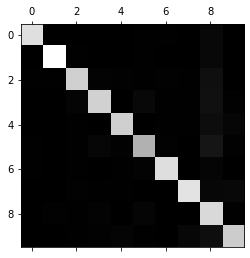

In [47]:
plt.matshow(conf_mat,cmap=plt.cm.gray)
plt.savefig('.\\ImageDataset\\ErrorAnalysis_ConfMatrix.jpeg')
plt.show()

In [50]:
row_sums=conf_mat.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mat/row_sums


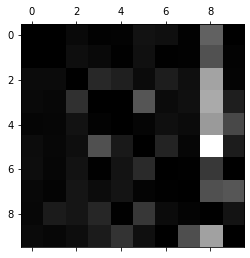

In [51]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.savefig('.\\ImageDataset\\DiagonalMatrix.jpeg')
plt.show()

In [54]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

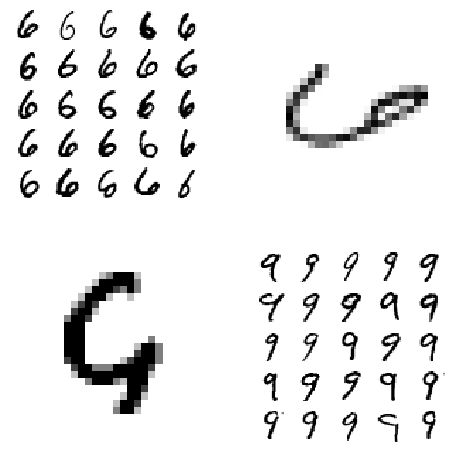

In [55]:
cl_a,cl_b=6,9

x_aa=x_train[(y_train==cl_a) & (y_train_pred==cl_a)]
x_ab=x_train[(y_train==cl_a) & (y_train_pred==cl_b)]
x_ba=x_train[(y_train==cl_b) & (y_train_pred==cl_a)]
x_bb=x_train[(y_train==cl_b) & (y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221);
plot_digits(x_aa[:25],images_per_row=5)
plt.subplot(222);
plot_digits(x_ab[:25],images_per_row=5)
plt.subplot(223);
plot_digits(x_ba[:25],images_per_row=5)
plt.subplot(224);
plot_digits(x_bb[:25],images_per_row=5)

plt.savefig('.\\ImageDataset\\PredictedValues.jpeg')
plt.show()

In [57]:
# Let's try MultiClass Classification using KNN Classifier

from sklearn.neighbors import KNeighborsClassifier 
y_train_large=(y_train >=7)
y_train_odd=(y_train%2 == 1)

y_multilabel=np.c_[y_train_large,y_train_odd]
knn=KNeighborsClassifier()
knn.fit(x_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn.predict([some_digits])

In [ ]:
y_train_knn_pred=cvpred(knn,x_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average="macro")

In [ ]:
noise=np.random.randint(0,100,(len(x_train),784))

x_train_mod=x_train+noise
noise=np.random.randint(0,100,(len(x_test),784))

x_test_mod=x_test+noise
y_train_mod=x_train
y_train_mod=x_test

In [62]:
knn.fit(x_train_mod,y_train_mod)
clean_digit=knn.predict([x_train_mod[some_index]])
plot_digits(clean_digit)

plt.savefig('.\\ImageDataset\\PredictedTestValues.jpeg')

ValueError: Found input variables with inconsistent numbers of samples: [60000, 10000]